In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time

# 设置输入流水线（input pipeline）

使用TFDS导入葡萄牙语-英语翻译数据集，包含50000条训练样本，1100条验证样本，2000条测试样本

In [3]:
# as_supervised: 
# bool, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label) according to builder.info.supervised_keys. 
# If False, the default, the returned tf.data.Dataset will have a dictionary with all the features.
# with_info: 
# bool, if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo) containing the info associated with the builder.
examples,metadata=tfds.load('ted_hrlr_translate/pt_to_en',with_info=True,as_supervised=True)
train_examples,val_examples=examples['train'],examples['validation']

## 创建子词分词器(subwords tokenizer)

Note: To generate a vocabulary from a corpus(语料库）, use tfds.features.text.SubwordTextEncoder.build_from_corpus.

```
build_from_corpus(
    cls,
    corpus_generator,
    target_vocab_size,
    max_subword_length=20,
    max_corpus_chars=None,
    reserved_tokens=None
)
```
- corpus_generator: generator yielding str, from which subwords will be constructed.
- target_vocab_size: int, approximate size of the vocabulary to create.


In [4]:
tokenizer_en=tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt,en in train_examples),target_vocab_size=2**13)
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples),target_vocab_size=2**13)

In [5]:
sample_string='Transformer is awesome !'

tokenized_string=tokenizer_en.encode(sample_string)

print(f'Tokenized string is {tokenized_string}')

origin_string=tokenizer_en.decode(tokenized_string)

print(f'Origin string is {origin_string}')

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 859]
Origin string is Transformer is awesome !


In [6]:
for s in tokenized_string:
    print(f'{s} --> {tokenizer_en.decode([s])}')

7915 --> T
1248 --> ran
7946 --> s
7194 --> former 
13 --> is 
2799 --> awesome
859 -->  !


In [7]:
BUFFER_SIZE=20000
BATCH_SIZE=64

添加开始与结束标记，我们可以使用数字编码vocab_size作为start的数字编码，vocab_size+1作为end的数字编码

In [8]:
def encode(inputs,targets):
    # 注意inputs，targets都是tensor
    inputs=[tokenizer_pt.vocab_size]+tokenizer_pt.encode(inputs.numpy())+[tokenizer_pt.vocab_size+1]
    targets=[tokenizer_en.vocab_size]+tokenizer_en.encode(targets.numpy())+[tokenizer_en.vocab_size+1]
    return inputs,targets

为了加快训练，删除长度超过40的数据

In [9]:
MAX_LENGTH=40

In [10]:
def filter_max_length(x,y,max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x)<=max_length,tf.size(y)<=max_length)

.map() 内部的操作以图模式（graph mode）运行，.map() 接收一个不具有 numpy 属性的图张量（graph tensor）。该分词器（tokenizer）需要将一个字符串或 Unicode 符号，编码成整数。因此，您需要在 tf.py_function 内部运行编码过程，tf.py_function 接收一个 eager 张量，该 eager 张量有一个包含字符串值的 numpy 属性。

tf.py_function:Wraps a python function into a TensorFlow op that executes it eagerly.
```
tf.py_function(
    func,
    inp,
    Tout,
    name=None
)
```

In [11]:
def tf_encode(pt,en):
    result_pt,result_en=tf.py_function(encode,[pt,en],[tf.int64,tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])
    return result_pt,result_en

In [12]:
# train_dataset = train_examples.map(encode) 报错： AttributeError: 'Tensor' object has no attribute 'numpy'
train_dataset=train_examples.map(tf_encode)

# dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3]) 
# dataset = dataset.filter(lambda x: x < 3) 
# list(dataset.as_numpy_iterator()) 
# [1,2]
# 依照filter——max——length的规则过滤内部元素
train_dataset=train_dataset.filter(filter_max_length)
train_dataset=train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE,padded_shapes=([-1],[-1]))
# 预读取一些元素，改善等待时间和加大吞吐量
# train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE,padded_shapes=([-1],[-1]))


In [13]:
pt_batch, en_batch = next(iter(train_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8214,   32,  294, ...,    0,    0,    0],
        [8214, 2119, 8003, ...,    0,    0,    0],
        [8214,  227,  343, ...,    0,    0,    0],
        ...,
        [8214,  113,    3, ...,    0,    0,    0],
        [8214, 3785,    7, ...,    0,    0,    0],
        [8214, 2395,  132, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8087,   14,   22, ...,    0,    0,    0],
        [8087,  105,    8, ...,    0,    0,    0],
        [8087, 7936,    8, ...,    0,    0,    0],
        ...,
        [8087,   63,    8, ...,    0,    0,    0],
        [8087,    3, 1046, ...,    0,    0,    0],
        [8087,   17,  149, ...,    0,    0,    0]])>)

## 位置编码（Positional encoding）

为了考虑输入序列中单词的词序，添加一个位置编码。
位置编码向量被加入到嵌入向量（Embedding Vector）中。嵌入表示一个 d 维空间的标记，在 d 维空间中有着相似含义的标记会离彼此更近。但是，嵌入并没有对在一句话中的词的相对位置进行编码。因此，当加上位置编码后，词将基于它们含义的相似度以及它们在句子中的位置，在 d 维空间中离彼此更近。
位置编码公式如下：
$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [14]:
def get_angles(pos,i,d_model):
    angle_rates=1/np.power(10000,(2*i//2)/np.float32(d_model))
    return pos*angle_rates

In [79]:
def positional_encoding(postion,d_model):
    angle_rads=get_angles(np.arange(postion)[:,np.newaxis],
                         np.arange(d_model)[np.newaxis,:],d_model)
    # 将sin应用于数组的偶数位置
    angle_rads[:,::2]=np.sin(angle_rads[:,::2])
    # 将cos应用于数组的奇数位置
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


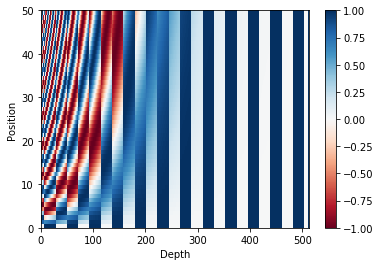

In [80]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 遮挡（Masking）

遮挡一批序列中所有的填充标记（pad tokens）。这确保了模型不会将填充作为输入。该 mask 表明填充值 0 出现的位置：在这些位置 mask 输出 1，否则输出 0。

In [24]:
def create_padding_mask(seq):
    seq=tf.cast(tf.math.equal(seq,0),tf.float32)
    # 添加额外的维度来将pad加到注意力对数（logits）
    return seq[:,tf.newaxis,tf.newaxis,:]


In [25]:
x=tf.constant([[1,2,3,0,0],[0,0,4,5,3],[2,0,10,3,0]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 0., 0., 0.]]],


       [[[0., 1., 0., 0., 1.]]]], dtype=float32)>

创建前沿遮挡（look-ahead-mask）。在预测的时候，我们只使用之前的单词，我们用改mask遮挡后续的标记。
如我们在预测第三个单词，只使用第一个，第二个单词，而不使用后面的，我们需要将后面的单词mask

In [26]:
def create_look_ahead_mask(size):
    mask=1-tf.linalg.band_part(tf.ones((size,size)),-1,0)
    return mask 

In [168]:
create_look_ahead_mask(size=5)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

## 自注意力（self-attention）

![self_attention](./pic/transformer1.png)

Transformer 使用的注意力函数有三个输入：Q（请求（query））、K（主键（key））、V（数值（value））。用于计算注意力权重的等式为：

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$


dk是向量的维度，点积注意力被缩小了维度的平方根倍。这样做是因为对于较大的维度值，点积的大小会增大，从而推动 softmax 函数往仅有很小的梯度的方向靠拢，导致了一种很硬的（hard）softmax。

例如，假设 Q 和 K 的均值为0，方差为1。它们的矩阵乘积将有均值为0，方差为 dk。因此，dk 的平方根被用于缩放（而非其他数值），因为，Q 和 K 的矩阵乘积的均值本应该为 0，方差本应该为1，这样会获得一个更平缓的 softmax。

遮挡（mask）与 -1e9（接近于负无穷）相乘。这样做是因为遮挡与缩放的 Q 和 K 的矩阵乘积相加，并在 softmax 之前立即应用。目标是将这些单元归零，因为 softmax 的较大负数输入在输出中接近于零。

![self-attention](./pic/transformer2.png)

In [30]:
def self_attention(q,k,v,mask):
    '''
    q, k, v 必须具有匹配的前置维度。
  k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
  虽然 mask 根据其类型（填充或前瞻）有不同的形状，
  但是 mask 必须能进行广播转换以便求和。
  
  参数:
    q: 查询的形状 == (..., seq_len_q, depth)
    k: 主键的形状 == (..., seq_len_k, depth)
    v: 数值的形状 == (..., seq_len_v, depth_v)
    mask: Float 张量，其形状能转换成
          (..., seq_len_q, seq_len_k)。默认为None。
    
  返回值:
    输出，注意力权重
    '''
    # tanspose_b=True  即 q @ k.T（转秩）
    mutmul_qk=tf.matmul(q,k,transpose_b=True) # (..., seq_len_q, seq_len_k)
    
    #  缩放
    dk=tf.cast(tf.shape(k)[-1],tf.float32)
    scaled_attention_logits=mutmul_qk/tf.math.sqrt(dk)
    
     # 进行mask
    if mask is not None:
        # 注意在mask中，填充0的位置对应是1
        # 1* -1e9 变为负无穷，计算出来的attention-logits中0位置加上负无穷
        # 在之后softmax中负无穷位置权重得分接近0，可以忽略
        # 这样就实现了对0的mask
        scaled_attention_logits+=(mask*-1e9)
    
    # 进行softmax计算得分，在最后一个轴上
    # 得到每个单词对句子中各个单词的关注度
    attention_weights=tf.nn.softmax(scaled_attention_logits,axis=-1) # (..., seq_len_q, seq_len_k)
    # 输出表示注意力权重和 V（数值）向量的乘积。这确保了要关注的词保持原样，而无关的词将被清除掉。
    output=tf.matmul(attention_weights,v)  # (..., seq_len_q, depth_v)
    
    return output,attention_weights
   
 

In [32]:
def print_out(q,k,v):
    temp_out,temp_attn=self_attention(q,k,v,None)
    print('attention weights are:')
    print(temp_attn)
    print('output is:')
    print(temp_out)

In [41]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,6,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## 多头注意力（Multi-head attention）

![](./pic/transformer3.png)

多头注意力由四部分组成：

- 线性层并分拆成多头。
- 按比缩放的点积自注意力。
- 多头连接。
- 最后一层线性层。
每个多头注意力块有三个输入：Q（请求）、K（主键）、V（数值）。这些输入经过线性（Dense）层，并分拆成多头。

将上面定义的 self_attention 函数应用于每个头（进行了广播（broadcasted）以提高效率）。注意力这步必须使用一个恰当的 mask。然后将每个头的注意力输出连接起来（用tf.transpose 和 tf.reshape），并放入最后的 Dense 层。

Q、K、和 V 被拆分到了多个头，而非单个的注意力头，因为多头允许模型共同注意来自不同表示空间的不同位置的信息。在分拆后，每个头部的维度减少，因此总的计算成本与有着全部维度的单个注意力头相同。

通过使用“Multi-headed”的机制来进一步完善self attention层。“Multi-headed”主要通过下面2中方式改善了attention层的性能：

1. 它拓展了模型关注不同位置的能力。在上面例子中可以看出，”The animal didn't cross the street because it was too tired”，我们的attention机制计算出“it”指代的为“animal”，这在对语言的理解过程中是很有用的。

2. 它为attention层提供了多个“representation subspaces”。在self attention中，我们有多个个Query / Key / Value权重矩阵（Transformer使用8个attention heads）。这些集合中的每个矩阵都是随机初始化生成的。然后通过训练，用于将词嵌入（或者来自较低Encoder/Decoder的矢量）投影到不同的“representation subspaces（表示子空间）”中。

In [58]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads):
        super(MultiHeadAttention,self).__init__()
        self.num_heads=num_heads
        self.d_model=d_model
        
        assert d_model%num_heads==0
        self.depth=d_model//self.num_heads
        
        self.wq=tf.keras.layers.Dense(d_model)
        self.wk=tf.keras.layers.Dense(d_model)
        self.wv=tf.keras.layers.Dense(d_model)
        self.dense=tf.keras.layers.Dense(d_model)
        
    def split_heads(self,x,batch_size):
        '''
        拆分最后一个维度到（num-heads，depth）
        转置之后性转为（batch-size，num-heads，seq-len，depth）
        '''
        # x传入时维度（batch-size，seq-len，d-model）
        # reshape之后（batch-size，seq-len，num-heads，depth）
        x=tf.reshape(x,(batch_size,-1,self.num_heads,self.depth))
#         example：
#         input_data.dims = (1, 4, 3)
#         perm = [1, 2, 0]
#         因为 output_data.dims[0] = input_data.dims[ perm[0] ]
#         因为 output_data.dims[1] = input_data.dims[ perm[1] ]
#         因为 output_data.dims[2] = input_data.dims[ perm[2] ]
#         所以得到 output_data.dims = (4, 3, 1)
#         output_data.dims = (4, 3, 1)
        return tf.transpose(x,perm=[0,2,1,3])# 交换第1个（seq-len）和第二个维度（num-heads）
   
    
    def call(self,v,k,q,mask):
        batch_size=tf.shape(q)[0]
        
        #wq,wk,wv是我们需要训练的三个权重矩阵
        v=self.wv(v) # (batch_size, seq_len, d_model)
        k=self.wk(k) # (batch_size, seq_len, d_model)
        q=self.wq(q) # (batch_size, seq_len, d_model)
        
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        
    
        # scaled_attention.shape=(batch_size,nums_heads,seq_len_q,depth)
        # 注意因为是多头， num-heads*depth=d-model
        scaled_attention,attention_weights=self_attention(q,k,v,mask)
        
        scaled_attention=tf.transpose(scaled_attention,perm=[0,2,1,3])# (batch_size,seq_len_q,num_heads,depth)
        
        concat_attention=tf.reshape(scaled_attention,(batch_size,-1,self.d_model))#(batch_size,seq_len_q,d_model)
        
        output=self.dense(concat_attention) # (batch_size,seq_len_q,d_model)
        
        return output,attention_weights

In [59]:
temp_mha=MultiHeadAttention(512,8)
y=tf.random.uniform((1,60,512))# (batch_size, encoder_sequence, d_model)
out,attention=temp_mha(y,y,y,None)
out.shape,attention.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## 点式前馈网络（Point wise feed forward network）

In [60]:
# 点式潜亏网络由两层全联接层组成，中间由Relu激活函数

In [64]:
def point_wise_ffn(d_model,dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff,activation='relu'), #(batch_size,seq_len,dff)
        tf.keras.layers.Dense(d_model )#(batch_size,seq_len,d_model)
    ])

In [66]:
sample_ffn=point_wise_ffn(512,2048)
sample_ffn((tf.random.uniform((64,50,512)))).shape

TensorShape([64, 50, 512])

## 编码器与解码器（encoder and decoder）
    

![encoder_decoder](./pic/transformer4.png)
输入语句经过N个编码器层，为序列中的每一个单词生成一个输出
解码器关注编码器的输出以及自身的输入（自注意力）来预测下一个词

### 编码器层

每一个编码器层包含一下子层：
1. 多头注意力（有填充遮挡）
2. 点式前馈网络

每个子层在其周围有一个残差连接，然后进行层归一化。残差连接有助于避免深度网络中的梯度消失问题。

每个子层的输出是 LayerNorm(x + Sublayer(x))。归一化是在 d_model（最后一个）维度完成的。Transformer 中有 N 个编码器层。

In [67]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,dff,rate=0.1):
        super(EncoderLayer,self).__init__()
        
        self.mha=MultiHeadAttention(d_model,num_heads)
        self.fnn=point_wise_ffn(d_model,dff)
        
        # epsilon: Small float added to variance to avoid dividing by zero.
        self.layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1=tf.keras.layers.Dropout(rate)
        self.dropout2=tf.keras.layers.Dropout(rate)
        
    def call(self,x,training,mask):
        attn_output,_=self.mha(x,x,x,mask) # (batch_size, input_seq_len, d_model)
#       training: Python boolean indicating whether the layer should behave in training mode (adding dropout) or in inference mode (doing nothing).
        attn_output=self.dropout1(attn_output,training=training)
        out1=self.layernorm1(x+attn_output) # (batch_size, input_seq_len, d_model)
        
        fnn_output=self.fnn(out1) # (batch_size, input_seq_len, d_model)
        fnn_output=self.dropout2(fnn_output,training=training)
        out2=self.layernorm2(out1+fnn_output)# (batch_size, input_seq_len, d_model)
        return out2


In [69]:
sample_encoder_layer=EncoderLayer(512,8,2048)
sample_encoder_layer_output=sample_encoder_layer(tf.random.uniform((64,43,512)),False,None)
sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

### 解码器层（Decoder layer）

解码器层包含一下子层：
1. 遮挡的多头注意力（前瞻遮挡和填充遮挡） 
2. 多头注意力（填充遮挡）。V（数值）和 K（主键）接收编码器输出作为输入。Q（请求）接收遮挡的多头注意力子层的输出。
3. 点式前馈网络

每个子层在其周围有一个残差连接，然后进行层归一化。每个子层的输出是 LayerNorm(x + Sublayer(x))。归一化是在 d_model（最后一个）维度完成的。

Transformer 中共有 N 个解码器层。

当 Q 接收到解码器的第一个注意力块的输出，并且 K 接收到编码器的输出时，注意力权重表示根据编码器的输出赋予解码器输入的重要性。换一种说法，解码器通过查看编码器输出和对其自身输出的自注意力，预测下一个词

In [74]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,dff,rate=0.1):
        super(DecoderLayer,self).__init__()
        
        self.mha1=MultiHeadAttention(d_model,num_heads)
        self.mha2=MultiHeadAttention(d_model,num_heads)
        
        self.fnn=point_wise_ffn(d_model,dff)
        
        self.layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1=tf.keras.layers.Dropout(rate)
        self.dropout2=tf.keras.layers.Dropout(rate)
        self.dropout3=tf.keras.layers.Dropout(rate)
        
    def call(self,x,enc_output,training,look_ahead_mask,padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1,attn_weights_block1=self.mha1(x,x,x,look_ahead_mask)# (batch_size, target_seq_len, d_model)
        attn1=self.dropout1(attn1,training=training)
        out1=self.layernorm1(x+attn1)
        
        attn2,attn_weights_block2=self.mha2(enc_output,enc_output,out1,padding_mask) # (batch_size, target_seq_len, d_model)
        attn2=self.dropout2(attn2)
        out2=self.layernorm2(out1+attn2) # (batch_size, target_seq_len, d_model)
        
        fnn_output=self.fnn(out2)
        fnn_output=self.dropout3(fnn_output)
        out3=self.layernorm3(out2+fnn_output)# (batch_size, target_seq_len, d_model)
        
        return out3,attn_weights_block1,attn_weights_block2
        
        
    

In [75]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### 编码器（Encoder）

编码器 包括：

1. 输入嵌入（Input Embedding）
2. 位置编码（Positional Encoding）
3. N 个编码器层（encoder layers）

输入经过嵌入（embedding）后，该嵌入与位置编码相加。该加法结果的输出是编码器层的输入。编码器的输出是解码器的输入。

In [88]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,num_layers,d_model,num_heads,dff,input_vocab_size,maximum_position_encoding,rate=0.1):
        super(Encoder,self).__init__()
        
        self.d_model=d_model
        self.num_layers=num_layers
        
        self.embedding=tf.keras.layers.Embedding(input_vocab_size,d_model)
        self.pos_encoding=positional_encoding(maximum_position_encoding,self.d_model)
        
        self.enc_layers=[EncoderLayer(d_model,num_heads,dff,rate) for _ in range(num_layers)]
        
        self.dropout=tf.keras.layers.Dropout(rate)
        
    def call(self,x,training,mask):
        seq_len=tf.shape(x)[1]
        
        # 将嵌入向量与位置编码相加
        x=self.embedding(x) #(batch_size,seq_len,d_model)
        x*=tf.math.sqrt(tf.cast(self.d_model,tf.float32))
        x+=self.pos_encoding[:,:seq_len,:]
        
        x=self.dropout(x,training=training)
        
        for i in range(self.num_layers):
            # mask pad的0
            # 在self-attention中，mask与-1e9相乘，pad 0位置对应变为-1e9（接近负无穷），这样softmax输出接近0
            x=self.enc_layers[i](x,training,mask)
            
        return x # (batch_size,input_seq_len,d_model)

In [89]:
sample_encoder=Encoder(num_layers=2,d_model=512,num_heads=8,
                      dff=2048,input_vocab_size=8500,
                      maximum_position_encoding=10000)
sample_encoder_output=sample_encoder(tf.random.uniform((64,62)),False,None)
sample_encoder_output.shape

TensorShape([64, 62, 512])

### 解码器（Decoder）

解码器包括：

1. 输出嵌入（Output Embedding）
2. 位置编码（Positional Encoding）
3. N 个解码器层（decoder layers）

目标（target）经过一个嵌入后，该嵌入和位置编码相加。该加法结果是解码器层的输入。解码器的输出是最后的线性层的输入。

In [94]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,num_layers,d_model,num_heads,dff,target_vocab_size,maximum_position_encoding,rate=0.1):
        super(Decoder,self).__init__()
        
        self.d_model=d_model
        self.num_layers=num_layers
        
        self.embedding=tf.keras.layers.Embedding(target_vocab_size,d_model)
        self.pos_encoding=positional_encoding(maximum_position_encoding,d_model)
        
        self.dec_layer=[DecoderLayer(d_model,num_heads,dff,rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self,x,enc_output,training,look_ahead_mask,padding_mask):
        seq_len=tf.shape(x)[1]
        attention_weights={}
        
        x=self.embedding(x) # (batch_size,seq_len,d_model)
        x*=tf.sqrt(tf.cast(self.d_model,tf.float32))
        x+=self.pos_encoding[:,:seq_len,:]
        
        x=self.dropout(x,training)
        
        for i in range(self.num_layers):
            x,attn_block1,attn_block2=self.dec_layer[i](x,enc_output,training,look_ahead_mask,padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)]=attn_block1
            attention_weights['decoder_layer{}_block2'.format(i+1)]=attn_block2
        
        # x.shape(batch_size,target_seq_len,d_model)
        return x,attention_weights

In [95]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## 创建Transformer

In [98]:
class Transformer(tf.keras.Model):
    def __init__(self,num_layers,d_model,num_heads,dff,
                 input_vocab_size,target_vocab_size,pe_input,pe_target,rate=0.1):
        super(Transformer,self).__init__()
        
        self.encoder=Encoder(num_layers,d_model,num_heads,dff,
                            input_vocab_size,pe_input,rate)
        
        self.decoder=Decoder(num_layers,d_model,num_heads,dff,
                            target_vocab_size,pe_target,rate)
        
        self.final_layer=tf.keras.layers.Dense(target_vocab_size)
        
    
    def call(self,inp,tar,training,enc_padding_mask,look_ahead_mask,dec_padding_mask):
        enc_output=self.encoder(inp,training,enc_padding_mask) #(batch_size,inp_seq_len,d_model)
        
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output,attn_weights=self.decoder(tar,enc_output,
                                             training,look_ahead_mask,dec_padding_mask)
        final_output=self.final_layer(dec_output)
        
        return final_output,attn_weights
         

In [99]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 26, 8000])

## 配置超参数（hyperparameters）

Transformer 的基础模型使用的数值为：num_layers=6，d_model = 512，dff = 2048。

In [111]:
num_layers=4
d_model=128
dff=512
num_heads=8
input_vocab_size=tokenizer_pt.vocab_size+2 #加上开始和结束标记
target_vocab_size=tokenizer_en.vocab_size+2
dropout_rate=0.1

## 优化器

根据论文中的公式，将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用。

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [112]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [115]:
learning_rate=CustomSchedule(d_model)

optimizer=tf.keras.optimizers.Adam(learning_rate,beta_1=0.9,beta_2=0.98,epsilon=1e-9)

Text(0, 0.5, 'learning rate')

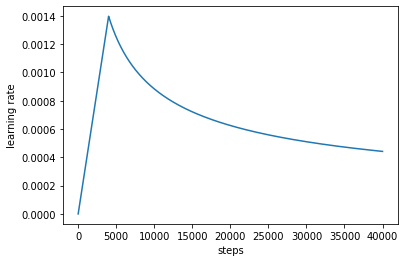

In [116]:
temp_learninig_rate_schedule=CustomSchedule(d_model)
plt.plot(temp_learninig_rate_schedule(tf.range(40000,dtype=tf.float32)))
plt.xlabel('steps')
plt.ylabel('learning rate')

## 损失函数与指标（Loss and metrics）

In [117]:
loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

In [118]:
def loss_function(y_true,y_pred):
    mask=tf.math.logical_not(tf.math.equal(y_true,0))
    loss=loss_object(y_true,y_pred)
    
    mask=tf.cast(mask,dtype=loss.dtype)
#     将padding处的loss去掉了
    loss*=mask
    
    return tf.reduce_mean(loss)

In [119]:
train_loss=tf.keras.metrics.Mean(name='train_loss')
train_accuracy=tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

## 训练与检查点（training and checkpoint）

In [120]:
transformer=Transformer(num_layers,d_model,num_heads,dff,input_vocab_size,
                       target_vocab_size,pe_input=input_vocab_size,
                       pe_target=target_vocab_size,rate=dropout_rate)

In [121]:
def create_masks(inp,tar):
    # 编码器pad mask，遮挡输入中的0
    enc_padding_mask=create_padding_mask(inp)
    
    # 解码器的第二个注意力模块使用
    # 该pad mask用于遮挡上一个编码器的输出
    dec_padding_mask=create_padding_mask(inp)
    
    # 解码器的第一个注意力模块使用
    # 用于填充和遮挡解码器获取到的输入的后续标记
    look_ahead_mask=create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask=create_padding_mask(tar)
    combined_mask=tf.maximum(dec_target_padding_mask,look_ahead_mask)
    
    return enc_padding_mask,combined_mask,dec_padding_mask

In [150]:
checkpoint_path='./checkpoints_transformer/train'
ckpt=tf.train.Checkpoint(transformer=transformer,optimizer=optimizer)

ckpt_manager=tf.train.CheckpointManager(ckpt,checkpoint_path,max_to_keep=5)

# 查看是否有检查点，有的话恢复最新检查点
# checkpoint中保存了训练了20个周期的参数
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('----load thr model----')

----load thr model----


In [148]:
tf.train.latest_checkpoint(checkpoint_path)

'./checkpoints_transformer/train/ckpt-4'

In [149]:
ckpt_manager.latest_checkpoint

'./checkpoints_transformer/train/ckpt-4'

目标（target）被分成了 tar_inp 和 tar_real。tar_inp 作为输入传递到解码器。tar_real 是位移了 1 的同一个输入：在 tar_inp 中的每个位置，tar_real 包含了应该被预测到的下一个标记（token）。

例如，sentence = "SOS A lion in the jungle is sleeping EOS"

tar_inp = "SOS A lion in the jungle is sleeping"

tar_real = "A lion in the jungle is sleeping EOS"

Transformer 是一个自回归（auto-regressive）模型：它一次作一个部分的预测，然后使用到目前为止的自身的输出来决定下一步要做什么。

在训练过程中，本示例使用了 teacher-forcing 的方法。无论模型在当前时间步骤下预测出什么，teacher-forcing 方法都会将真实的输出传递到下一个时间步骤上。

当 transformer 预测每个词时，自注意力（self-attention）功能使它能够查看输入序列中前面的单词，从而更好地预测下一个单词。

为了防止模型在期望的输出上达到峰值，模型使用了前瞻遮挡（look-ahead mask）。

In [151]:
EPOCHS=10

In [152]:
# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。


train_step_signature=[
    # Metadata for describing the tf.Tensor objects accepted or returned by some TensorFlow APIs.
    tf.TensorSpec(shape=(None,None),dtype=tf.int64),
    tf.TensorSpec(shape=(None,None),dtype=tf.int64)
]

@tf.function(input_signature=train_step_signature)
def train_step(inp,tar):
    tar_inp=tar[:,:-1]
    tar_real=tar[:,1:]
    
    enc_padding_mask,combined_mask,dec_padding_mask=create_masks(inp,tar_inp)
    
    with tf.GradientTape() as tape:
        predictions,_=transformer(inp,tar_inp,True,enc_padding_mask,
                                 combined_mask,dec_padding_mask)
        loss=loss_function(tar_real,predictions)
    gradients=tape.gradient(loss,transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients,transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real,predictions)

In [153]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
    
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                  epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9867 Accuracy 0.1512
Epoch 1 Batch 50 Loss 1.9338 Accuracy 0.1682
Epoch 1 Batch 100 Loss 1.8591 Accuracy 0.1796
Epoch 1 Batch 150 Loss 1.8025 Accuracy 0.1870
Epoch 1 Batch 200 Loss 1.7539 Accuracy 0.1926
Epoch 1 Batch 250 Loss 1.7038 Accuracy 0.1969
Epoch 1 Batch 300 Loss 1.6674 Accuracy 0.2020
Epoch 1 Batch 350 Loss 1.6316 Accuracy 0.2061
Epoch 1 Batch 400 Loss 1.5970 Accuracy 0.2099
Epoch 1 Batch 450 Loss 1.5681 Accuracy 0.2131
Epoch 1 Batch 500 Loss 1.5421 Accuracy 0.2157
Epoch 1 Batch 550 Loss 1.5175 Accuracy 0.2185
Epoch 1 Batch 600 Loss 1.4920 Accuracy 0.2208
Epoch 1 Batch 650 Loss 1.4704 Accuracy 0.2231
Epoch 1 Batch 700 Loss 1.4493 Accuracy 0.2255
Epoch 1 Loss 1.4488 Accuracy 0.2255
Time taken for 1 epoch: 393.6630337238312 secs

Epoch 2 Batch 0 Loss 1.2105 Accuracy 0.2612
Epoch 2 Batch 50 Loss 1.1058 Accuracy 0.2676
Epoch 2 Batch 100 Loss 1.0902 Accuracy 0.2676
Epoch 2 Batch 150 Loss 1.0801 Accuracy 0.2691
Epoch 2 Batch 200 Loss 1.0679 Accuracy 0.2697
Ep

## 评估

以下步骤用于评估：

- 用葡萄牙语分词器（tokenizer_pt）编码输入语句。此外，添加开始和结束标记，这样输入就与模型训练的内容相同。这是编码器输入。
- 解码器输入为 start token == tokenizer_en.vocab_size。
- 计算填充遮挡和前瞻遮挡。
- 解码器通过查看编码器输出和它自身的输出（自注意力）给出预测。
- 选择最后一个词并计算它的 argmax。
- 将预测的词连接到解码器输入，然后传递给解码器。
- 在这种方法中，解码器根据它预测的之前的词预测下一个。

Note：这里使用的模型具有较小的能力以保持相对较快，因此预测可能不太正确。要复现论文中的结果，请使用全部数据集，并通过修改上述超参数来使用基础 transformer 模型或者 transformer XL。

In [158]:
def evaluate(inp_sentence):
    start_token=[tokenizer_pt.vocab_size]
    end_token=[tokenizer_pt.vocab_size+1]
    
    # 对输入语句增加start-token与end-token
    inp_sentence=start_token+tokenizer_pt.encode(inp_sentence)+end_token
    encoder_input=tf.expand_dims(inp_sentence,axis=0)
    
    # 目标语句是英语，transformer解码器的第一个输入是英语的start-token
    decoder_input=[tokenizer_en.vocab_size]
    output=tf.expand_dims(decoder_input,0)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask,combined_mask,dec_padding_mask=create_masks(encoder_input,output)
        
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions,attention_weights=transformer(encoder_input,output,
                                                 False,enc_padding_mask,
                                                 combined_mask,dec_padding_mask)
        
        # 从seq-len维度选择最后一个词
        predictions=predictions[:,-1:,:] # batch_size,1,vocab_size
        
        predicted_id=tf.cast(tf.argmax(predictions,-1),tf.int32)
        
        # 预测单词是结束标记
        if predicted_id==tokenizer_en.vocab_size+1:
            return tf.squeeze(output,axis=0),attention_weights
        
        # 连接predicted_id与输出，作为解码器的输入传入解码器
        output=tf.concat([output,predicted_id],axis=-1)
        
    return tf.squeeze(output,axis=0),attention_weights

        
            

In [159]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
  
    sentence = tokenizer_pt.encode(sentence)
  
    attention = tf.squeeze(attention[layer], axis=0)
  
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
    
        # 画出注意力权重
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}
    
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))
    
        ax.set_ylim(len(result)-1.5, -0.5)
        
        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)
    
        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)
    
        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

In [160]:
def translate(sentence,plot=''):
    result,attention_weights=evaluate(sentence)
    
    predicted_sentence=tokenizer_en.decode([i for i in result if i <tokenizer_en.vocab_size])
    
    print(f'Input: {sentence}')
    print(f'Predicted sentence is: {predicted_sentence}')
    
    if plot:
        plot_attention_weights(attention_weights,sentence,result,plot)

In [174]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted sentence is: this is a problem that we need to solve our ...c .
Real translation: this is a problem we have to solve .


In [163]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted sentence is: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [165]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted sentence is: so i 'm very quickly sharing with you some stories of some magic things that happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


Input: este é o primeiro livro que eu fiz.
Predicted sentence is: this is the first book i did .


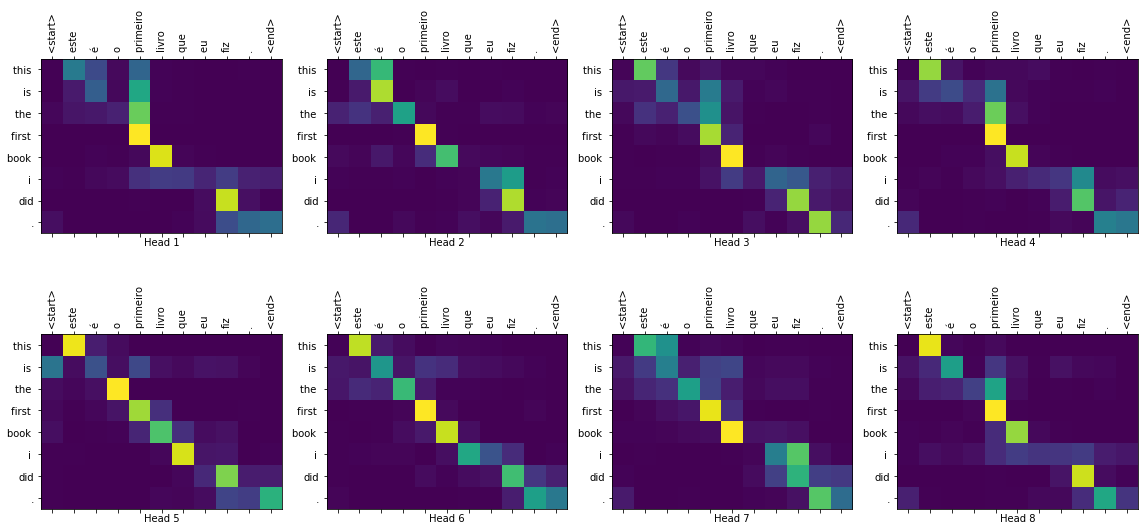

Real translation: this is the first book i've ever done.


In [177]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")